In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import torch.optim as optim
from pytorch_msssim import ssim, SSIM
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Preparation
- In case InVEST model error and the outputs weren't successfully generated, the samples should not be included in the training.
- Splitting the data into train, test, and validation.
- After splitting the data, calculate normalization parameters.

In [12]:
# Paths to input and output directories
os.chdir('E:/Coding/CNN_InV_ReOrg')
input_dir = 'Prosd'
output_dir = 'Results'
split_dir = 'Fix_Sets'
checkpoint_dir = 'Checkpoints'


In [4]:
# Code to reload the file IDs
def load_file_ids(split_dir, split_name):
    csv_path = os.path.join(split_dir, f'{split_name}_ids.csv')
    return pd.read_csv(csv_path)['file_id'].tolist()

# Reload the split IDs
train_ids = load_file_ids(split_dir, 'train')
val_ids = load_file_ids(split_dir, 'val')
test_ids = load_file_ids(split_dir, 'test')

# load normalization parameters
normp = np.load('Normal/normalization_params.npy', allow_pickle=True).item()

# Dataloader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, input_dir, output_dir, file_ids, transform=None, preload=True ,normalization_file='Normal/normalization_params.npy'):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.file_ids = file_ids
        self.transform = transform
        self.num_categories = 14  # Categories 1-12, 254->13, 255->14
        self.preload = preload
        self.data_cache = {}
        self.normalization_file = normalization_file
        self.mean_channel_1 = 0.0
        self.std_channel_1 = 1.0
        self.mean_channel_2 = 0.0
        self.std_channel_2 = 1.0
        
        # Load normalization parameters if they exist
        if os.path.exists(self.normalization_file):

            params = np.load(self.normalization_file, allow_pickle=True).item()
            self.min_channel_1 = params['min_channel_1']
            self.max_channel_1 = params['max_channel_1']
            self.mean_channel_1 = params['mean_channel_1']
            self.std_channel_1 = params['std_channel_1']
            self.min_channel_2 = params['min_channel_2']
            self.max_channel_2 = params['max_channel_2']
            self.mean_channel_2 = params['mean_channel_2']
            self.std_channel_2 = params['std_channel_2']
            self.min_gt_channel_2 = params['min_gt_channel_2']
            self.max_gt_channel_2 = params['max_gt_channel_2']
            self.mean_gt_channel_2 = params['mean_gt_channel_2']
            self.std_gt_channel_2 = params['std_gt_channel_2']
        else:
            print(f"Normalization file not found at {self.normalization_file}. Using default values.")

        if self.preload:

            for fid in tqdm(self.file_ids, desc="Pre-loading data into memory..."):
                input_path = os.path.join(self.input_dir, f'{fid}.pt')
                gt_path = os.path.join(self.output_dir, f'{fid}_res.pt')
                try:
                    input_tensor = torch.load(input_path, weights_only=True).squeeze(1)
                    gt_tensor = torch.load(gt_path, weights_only=True).squeeze(1)

                    # Process first channel
                    first_channel = input_tensor[0, :, :]
                    first_channel[first_channel == 254] = 13
                    first_channel[first_channel == 255] = 14
                    first_channel = first_channel - 1  # Adjust labels to start from 0

                    # One-hot encode and reshape
                    first_channel_ohe = F.one_hot(first_channel.long(), num_classes=self.num_categories)
                    first_channel_ohe = first_channel_ohe.permute(2, 0, 1)  # Shape: (num_categories, 512, 512)

                    # Concatenate with other channels
                    other_channels = input_tensor[1:, :, :].float()
                    other_channels[0] = (other_channels[0] - self.min_channel_1) / (self.max_channel_1 - self.min_channel_1 + 1e-8)
                    other_channels[1] = (other_channels[1] - self.min_channel_2) / (self.max_channel_2 - self.min_channel_2 + 1e-8)

                    gt_second_channel = (gt_tensor[2] - self.mean_gt_channel_2) / (self.std_gt_channel_2 + 1e-8)
                    gt_second_channel = torch.sign(gt_second_channel) * torch.log(torch.abs(gt_second_channel) + 1)
                    other_gt_channels = gt_tensor[:2]

                    final_input = torch.cat((first_channel_ohe.float(), other_channels.float()), dim=0)
                    final_gt = torch.cat((other_gt_channels, gt_second_channel.unsqueeze(0)), dim=0)

                    self.data_cache[fid] = (final_input, final_gt)

                except Exception as e:
                    print(f"Skipping problematic sample {fid} due to error: {e}")

                
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        fid = self.file_ids[idx]

        if self.preload and fid in self.data_cache:
            final_input, gt_tensor = self.data_cache[fid]
        else:
            input_path = os.path.join(self.input_dir, f'{fid}.pt')
            gt_path = os.path.join(self.output_dir, f'{fid}_res.pt')

            try:
                input_tensor = torch.load(input_path, weights_only=True).squeeze(1)
                gt_tensor = torch.load(gt_path, weights_only=True).squeeze(1)

                # Process first channel
                first_channel = input_tensor[0, :, :]
                first_channel[first_channel == 254] = 13
                first_channel[first_channel == 255] = 14
                first_channel = first_channel - 1  # Adjust labels to start from 0

                # One-hot encode and reshape
                first_channel_ohe = F.one_hot(first_channel.long(), num_classes=self.num_categories)
                first_channel_ohe = first_channel_ohe.permute(2, 0, 1)  # Shape: (num_categories, 512, 512)

                # Concatenate with other channels
                other_channels = input_tensor[1:, :, :]
                other_channels[0] = (other_channels[0] - self.min_channel_1) / (self.max_channel_1 - self.min_channel_1 + 1e-8)
                other_channels[1] = (other_channels[1] - self.min_channel_2) / (self.max_channel_2 - self.min_channel_2 + 1e-8)

                
                gt_second_channel = (gt_tensor[2] - self.mean_gt_channel_2) / (self.std_gt_channel_2 + 1e-8)
                gt_second_channel = torch.sign(gt_second_channel) * torch.log(torch.abs(gt_second_channel) + 1)
                other_gt_channels = gt_tensor[:2]

                final_input = torch.cat((first_channel_ohe.float(), other_channels.float()), dim=0)
                final_gt = torch.cat((other_gt_channels, gt_second_channel.unsqueeze(0)), dim=0)
                self.data_cache[fid] = (final_input, final_gt)

            except Exception as e:
                print(f"Skipping problematic sample {fid} due to error: {e}")
                return None  # Return None for problematic samples

        if self.transform:
            final_input = self.transform(final_input)
            gt_tensor = self.transform(gt_tensor)

        return final_input, gt_tensor.float()

# Adjust DataLoader to handle None values
def custom_collate_fn(batch):
    # Filter out None samples
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None  # Handle edge case where all samples are None
    return torch.utils.data.dataloader.default_collate(batch)


In [6]:
# Create datasets
train_dataset = CustomDataset(input_dir, output_dir, train_ids, preload=True)
val_dataset = CustomDataset(input_dir, output_dir, val_ids, preload=True)
test_dataset = CustomDataset(input_dir, output_dir, test_ids, preload=True)

# Update DataLoader initialization

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn, pin_memory=True)

Pre-loading data into memory...: 100%|██████████| 2/2 [00:00<00:00, 67.88it/s]


# Surrogate Model Architecture
## U-Net

In [7]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block to recalibrate feature maps."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2, 3))  # Global average pooling
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        y = y.view(b, c, 1, 1)
        return x * y


class UNet(nn.Module):
    def __init__(self, in_channels=16, out_channels=3):
        super(UNet, self).__init__()
        # Define the encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder with skip connections
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)  # Concatenate
        self.se4 = SEBlock(512)  # Add SE attention to skip connection

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.se3 = SEBlock(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.se2 = SEBlock(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        self.se1 = SEBlock(64)

        # Output layer
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with SE-based attention for skip connections
        up4 = self.upconv4(b)
        skip4 = self.se4(e4)
        merge4 = torch.cat([up4, skip4], dim=1)
        d4 = self.decoder4(merge4)

        up3 = self.upconv3(d4)
        skip3 = self.se3(e3)
        merge3 = torch.cat([up3, skip3], dim=1)
        d3 = self.decoder3(merge3)

        up2 = self.upconv2(d3)
        skip2 = self.se2(e2)
        merge2 = torch.cat([up2, skip2], dim=1)
        d2 = self.decoder2(merge2)

        up1 = self.upconv1(d2)
        skip1 = self.se1(e1)
        merge1 = torch.cat([up1, skip1], dim=1)
        d1 = self.decoder1(merge1)

        # Output
        out = self.conv_last(d1)
        # out = torch.sigmoid(out)
        return out


## Attention UNet

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=16, out_channels=3):
        super(AttentionUNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with attention blocks for skip connections
        up4 = self.upconv4(b)
        att4 = self.att4(up4, e4)
        merge4 = torch.cat([up4, att4], dim=1)
        d4 = self.decoder4(merge4)

        up3 = self.upconv3(d4)
        att3 = self.att3(up3, e3)
        merge3 = torch.cat([up3, att3], dim=1)
        d3 = self.decoder3(merge3)

        up2 = self.upconv2(d3)
        att2 = self.att2(up2, e2)
        merge2 = torch.cat([up2, att2], dim=1)
        d2 = self.decoder2(merge2)

        up1 = self.upconv1(d2)
        att1 = self.att1(up1, e1)
        merge1 = torch.cat([up1, att1], dim=1)
        d1 = self.decoder1(merge1)

        # Output
        out = self.final(d1)
        return out


# Performance Evaluation

In [15]:
# load model
pltname = '0204UNet.pth'
modelpath = os.path.join(split_dir, checkpoint_dir, pltname)
using_loader = test_loader
model = UNet(in_channels=16, out_channels=3)
modelname = 'UNet'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Assuming the model, test_loader, and device are already defined
checkpoint = torch.load(modelpath, map_location=device)
# if 'best' in modelpath, load checkpoint, if not , load checkpoint['model_state_dict']
if 'best' in modelpath:
    model.load_state_dict(checkpoint)
else:
    model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
print(f"Model loaded from {modelpath}")

Model loaded from Fix_Sets\Checkpoints\0204UNet.pth


### Plot Loss Progression

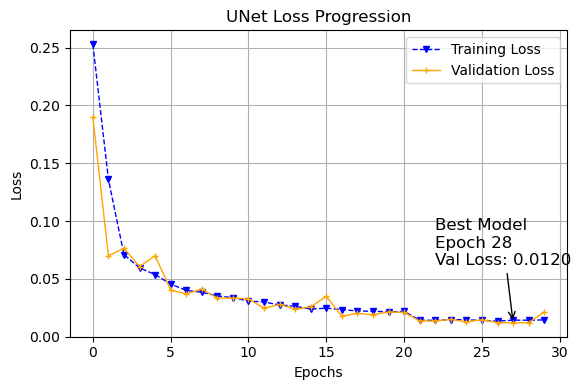

In [ ]:
checkpoint['training_loss']
# plot loss progression, using checkpoint['training_loss'] and checkpoint['validation_loss']
fig, ax = plt.subplots(figsize=(6, 4))
# plot training loss, square marker
ax.plot(checkpoint['training_loss'], label='Training Loss', color='blue', linestyle='--', marker='v', linewidth=1, markersize=4)
# plot validation loss
ax.plot(checkpoint['validation_loss'], label='Validation Loss', color='orange', marker='+', linewidth=1, markersize=4)
# annotate the best model (lowest validation loss)
best_val_loss = min(checkpoint['validation_loss'])
best_val_loss_epoch = checkpoint['validation_loss'].index(best_val_loss)
ax.annotate(f'Best Model\nEpoch {best_val_loss_epoch+1}\nVal Loss: {best_val_loss:.4f}', xy=(best_val_loss_epoch, best_val_loss), xytext=(best_val_loss_epoch-5, best_val_loss+0.05), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12, color='black')
# Add labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(f'{modelname} Loss Progression')
ax.legend()
plt.grid(True)
# tight layout
plt.tight_layout()
plt.show()
# save 
# plt.savefig(f'{pltname}_Loss_Progression.png', dpi=300)
# plt.savefig(f'{pltname}_Loss_Progression.pdf', dpi=300)


### Plot Actual vs. Prediction

In [ ]:

# Initialize lists to store the actual and predicted values
channel_0_predictions = []
channel_0_actuals = []
channel_1_predictions = []
channel_1_actuals = []
channel_2_predictions = []
channel_2_actuals = []

# Iterate over the entire test dataset
with torch.no_grad():
    for inputs, targets in using_loader:
        # Move the tensors to the correct device
        inputs, targets = inputs.to(device), targets.to(device)
        model.to(device)
        model.eval()
        # Get the prediction
        prediction = model(inputs)
        # print(len(prediction))
        
        for i in range(len(prediction)):
        # Append the predictions and actual values to the lists
            channel_0_predictions.append(prediction[i][0].cpu().numpy().mean())
            channel_0_actuals.append(targets[i][0].cpu().numpy().mean())
            channel_1_predictions.append(prediction[i][1].cpu().numpy().mean())
            channel_1_actuals.append(targets[i][1].cpu().numpy().mean())
            channel_2_predictions.append(prediction[i][2].cpu().numpy().mean())
            channel_2_actuals.append(targets[i][2].cpu().numpy().mean())
            # print max and min for target[i][2]
            # print(f"Channel {2} max value: {torch.max(prediction[i][2]),torch.max(targets[i][2])}")
            # print(f"Channel {2} min value: {torch.max(prediction[i][2]), torch.min(targets[i][2])}")

# Concatenate all batches

# Calculate the mean of actual and predicted values along the spatial dimensions
# save into pd dataframe and csv
modelprf = pd.DataFrame()
modelprf['channel_0_predictions'] = channel_0_predictions
modelprf['channel_0_actuals'] = channel_0_actuals
modelprf['channel_1_predictions'] = channel_1_predictions
modelprf['channel_1_actuals'] = channel_1_actuals
modelprf['channel_2_predictions'] = channel_2_predictions
modelprf['channel_2_actuals'] = channel_2_actuals

# modelprf.to_csv('attUNETmodelprf.csv', index=False)


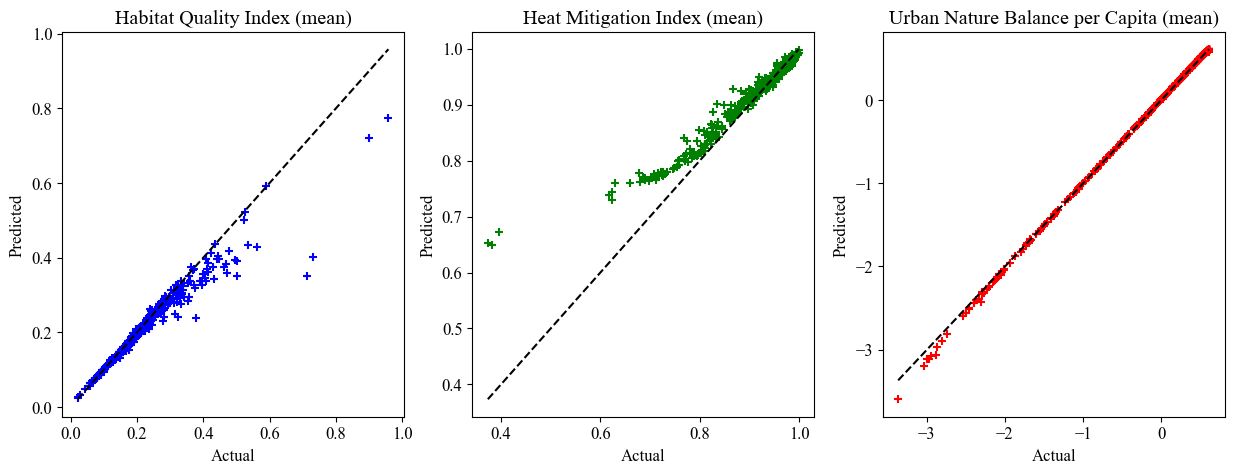

In [ ]:

# Change the global font settings
plt.rcParams['font.family'] = 'serif'  # or 'sans-serif', 'monospace', etc.
plt.rcParams['font.serif'] = ['Times New Roman']  # Specify the serif font
plt.rcParams['font.size'] = 12  # Set the default font size

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Channel 0, scatter of mean values
axes[0].scatter(channel_0_actuals, channel_0_predictions, marker='+', color='blue')
# min max line
axes[0].plot([np.array(channel_0_actuals).min(), np.array(channel_0_actuals).max()], [np.array(channel_0_actuals).min(), np.array(channel_0_actuals).max()], color='black', linestyle='--')
axes[0].set_title('Habitat Quality Index (mean)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Channel 1
axes[1].scatter(channel_1_actuals, channel_1_predictions, marker='+', color='green')
axes[1].plot([np.array(channel_1_actuals).min(), np.array(channel_1_actuals).max()], [np.array(channel_1_actuals).min(), np.array(channel_1_actuals).max()], color='black', linestyle='--')
axes[1].set_title('Heat Mitigation Index (mean)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Channel 2
axes[2].scatter(channel_2_actuals, channel_2_predictions, marker='+', color='red')
axes[2].plot([np.array(channel_2_actuals).min(), np.array(channel_2_actuals).max()], [np.array(channel_2_actuals).min(), np.array(channel_2_actuals).max()], color='black', linestyle='--')
axes[2].set_title('Urban Nature Balance per Capita (mean)')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

# save plot
# plt.savefig(f'{pltname}.png')
# plt.savefig(f'{pltname}.pdf')

### Calculate R square, MAE, RMSE

In [32]:
# calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate R^2, MAE, and RMSE for each channel
for i, (actuals, predictions) in enumerate(zip([channel_0_actuals, channel_1_actuals, channel_2_actuals], [channel_0_predictions, channel_1_predictions, channel_2_predictions])):
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    print(f"Channel {i} - R^2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# save as text file
with open(f'E:/Coding/CNN_InV/Figure/{pltname}.txt', 'w') as f:
    for i, (actuals, predictions) in enumerate(zip([channel_0_actuals, channel_1_actuals, channel_2_actuals], [channel_0_predictions, channel_1_predictions, channel_2_predictions])):
        r2 = r2_score(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))

        f.write(f"Channel {i} - R^2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}\n")

Channel 0 - R^2: 0.9302, MAE: 0.0097, RMSE: 0.0258
Channel 1 - R^2: 0.9179, MAE: 0.0115, RMSE: 0.0211
Channel 2 - R^2: 0.9996, MAE: 0.0087, RMSE: 0.0167
